In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as pl

from compute_k import CochlearModel

from functools import partial
from Lee_et_al.Lee_data import df_gain, df_phase

In [2]:
pl.rcParams.update({
    'font.size': 14,          # controls default text sizes
    'axes.titlesize': 16,     # fontsize of the axes title
    'axes.labelsize': 14,     # fontsize of the x and y labels
    'xtick.labelsize': 12,    # fontsize of the tick labels
    'ytick.labelsize': 12,    # fontsize of the tick labels
    'legend.fontsize': 12,    # fontsize of the legend
    'figure.titlesize': 18,   # fontsize of the figure title
})

In [3]:
#cochl=CochlearModel(mu=0.15) #Sisto's params   #mu=0.150

cochl=CochlearModel(mu=0.150, H=170e-6, L=6e-3) # mouse data mu=0.15
#cochl=CochlearModel(L=1.21e-2)

### Create cochlear partition

In [4]:
#peak traveling wave is not the same as f_bm: correction (from simulations)
#ratio f probe/f_bm at the peak
f_p_to_f_bm=0.56


In [5]:
n_sections=1000

cochl.createCochlPart(n_sections)
cochl.createCochlPart(n_sections, A=1/f_p_to_f_bm*2*np.pi*120850, B=-826.56) # (mouse)
#cochl.createCochlPart(n_sections, A=2*np.pi*50216, B=-np.log(10)*181) #Gerbil model

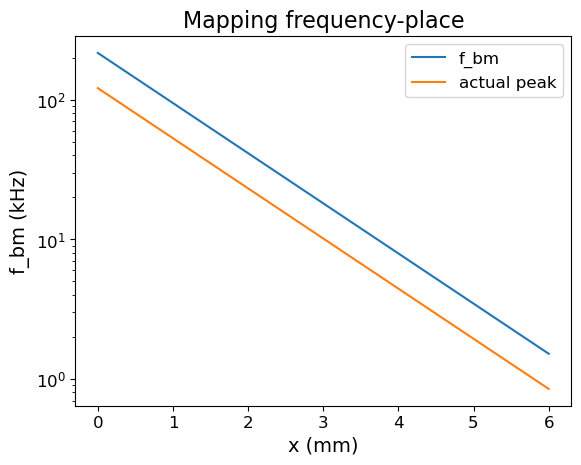

In [6]:
pl.plot(cochl.x*1e3, cochl.omega_bm_x/(2*np.pi)/1e3, label='f_bm')
pl.plot(cochl.x*1e3, cochl.omega_bm_x/(2*np.pi)/1e3*f_p_to_f_bm, label='actual peak')
pl.title('Mapping frequency-place')
pl.xlabel('x (mm)')
pl.ylabel('f_bm (kHz)')
pl.yscale('log')
pl.legend()

### Plot k, alpha as a function of place

In [7]:
f_p=10000  #f probe
omega_p=2*np.pi*f_p
x_p=cochl.compute_x(f_p)

omega_bm=cochl.omega_bm_x

In [8]:
G_max=1.5
G_min=0.
num_G=8

In [9]:
scaling_symmetry=True
cochl.activate_scaling_symmetry(scaling_symmetry)

In [10]:
n_levels=8

G_arr=np.linspace(1.3, 0.5, num=n_levels)  #regular

a_arr=np.ones_like(G_arr)  #use function for modifiers of visc instead

ratio_arr=3+np.arange(n_levels)/n_levels*(1.7- 3)  # v_TM/v_BM

Modifiers of viscosity

In [11]:
def myGaussian(x, amp=1., x_0=1., sig=0.1, x_corr=1.):
    x=x_corr*x
    return amp*np.exp(-(x-x_0)**2/(2*sig**2))

def mySigm(x, a=1, b=10, c=1.):
    u=a*(x*10/f_p_to_f_bm-b)
    
    #to avoid overflow:
    u=np.minimum(u, 10)
    return c/(1+np.exp(u))
    
sigm_params=np.array([[ 9,   9.25172014, 1.],
       [  7,   9.09880006, 1.],
       [  6.40507369,   8.5820274, 1.],
       [  5,   7.82665505, 1.],
       [  3.68563426,   6.91697016, 1.],
       [  2.56864946,   6.36354728, 1.],
       [  0.67252845,   5.92042992, 1.],
       [  0.79895779, -10.07136564, 1.]]) #with some modifs



In [12]:
myFuncs=[partial(mySigm, a=param_[0], b=param_[1], c=param_[2]) for param_ in sigm_params]

#HACK no modif of viscous loss
#myFuncs=[None for G in G_arr]  #no change viscosity  #or:
#myFuncs=[lambda x: np.zeros_like(x) for G in G_arr]
#myFuncs=[lambda x: np.ones_like(x) for G in G_arr] #no TM viscous load
#myFuncs=[lambda x: 0.9*np.ones_like(x) for G in G_arr] #reduction 90%

Text(0.5, 0, 'f/f_peak')

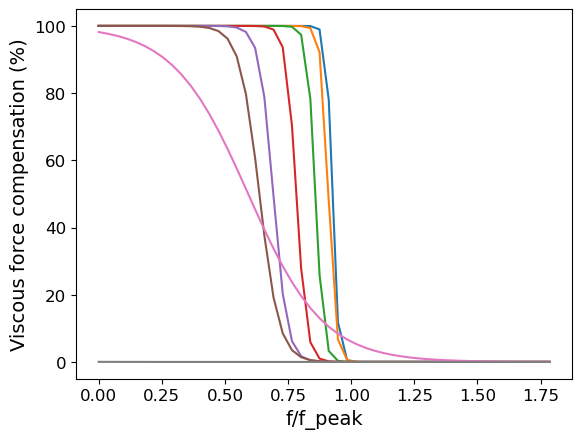

In [13]:

for myFunc in myFuncs:
    x=np.linspace(0, 1)
    pl.plot(x/f_p_to_f_bm, myFunc(x)*100)
    
pl.ylabel('Viscous force compensation (%)')
pl.xlabel('f/f_peak')

In [14]:

k_arr=[]

def compute_k(omega_bm, a, G, omega_p, funcVisc=None):
    
    k_init=k = cochl.k_init(omega_bm, G, omega_p)

    for nit in range(1, 31):
        k=cochl.k_it(omega_bm, a, G, k, omega_p, funcVisc=myFunc)
    return k

for a, G, ratio_v, myFunc in zip(a_arr, G_arr, ratio_arr, myFuncs):
    
    cochl.set_constant_mult_factor(ratio_v) #NOTE: Mult factor is set outside of compute_k /!\
    
    k=compute_k(omega_bm, a, G, omega_p, funcVisc=myFunc)
    k_arr.append(k)
    

In [15]:
def plot_k(k, ratio_v, label='', plot_CF=False):
    x_min=0
    x_max=4.2
    #x_max=0.95*x_p*1e3
    
    x=cochl.x
    x_label='x (mm)'

    x_p=globals()['x_p'] #use value from global variable, consistency with previous code
    
    if plot_CF:
        x=cochl.omega_bm_x/(2*np.pi)  #X AXIS: CF instead
        x=x*1e-6  #to have axes in kHz
        x_label='f_bm (kHz)'
        x_p=f_p*1e-6
        x_min=0.6*f_p*1e-3
        x_max=30
    pl.subplot(3, 2, 1)

    pl.plot(x*1e3, np.real(k)*1e-3)
    pl.axvline(x_p*1e3, label='f=f_bm', color='lightgray')
        
    pl.xlim([x_min, x_max])
    pl.ylim([-5, 50])

    pl.ylabel('Re(k)  (1/mm)')

    pl.xlabel(x_label)


    pl.subplot(3, 2, 2)

    pl.plot(x*1e3, np.imag(k)*1e-3)
    pl.axvline(x_p*1e3, label='f=f_bm', color='lightgray')
        
            
    pl.xlim([x_min, x_max])
    pl.ylim([-15, 5])
    
    pl.xlabel(x_label)
    pl.ylabel('Im(k)  (1/mm)')



    pl.subplot(3, 2, 3)

    pl.plot(x*1e3, np.abs(k)*1e-3)
    pl.axvline(x_p*1e3, label='f=f_bm', color='lightgray')
    
    
    pl.xlim([x_min, x_max])
    pl.ylim([0, 150])

    pl.xlabel(x_label)
    pl.ylabel('abs(k)  (1/mm)')
    
    pl.subplot(3, 2, 4)

    pl.plot(x*1e3, np.angle(k), label=label)
    pl.axvline(x_p*1e3, color='lightgray')
        
    
    pl.xlabel(x_label)
    pl.ylabel('Phase (k)')

    
    pl.xlim([x_min, x_max])
    pl.ylim([-2, 1])


    pl.legend(bbox_to_anchor=(1.1, 1.), loc='upper left')

    pl.subplot(3, 2, 5)
    
    cochl.set_constant_mult_factor(ratio_v)  
    #k_z=k/np.sqrt(2)
    ratio_vrl=cochl._mult_factor
    
    pl.plot(x*1e3, ratio_vrl*np.ones_like(x)) #for constant ratio
    
    pl.ylabel('v_rl/v_BM, magnitude')


    pl.xlim([0, x_max])
    pl.xlabel(x_label)
    pl.ylim([0, 20])

    #alternative plot: ratio v_up/v_bottom for TM
    
    pl.subplot(3, 2, 6)

    k_z=k/np.sqrt(2)
    ratio_vtm=np.abs(np.exp(-k_z*cochl.H_TM))
    
    pl.plot(x*1e3, ratio_vtm, label=label)
    pl.axvline(x_p*1e3, color='lightgray')
    
    pl.xlim([0, x_max])
    pl.ylim([0.5,1.2])
    pl.grid(True)
    pl.xlabel(x_label)
    
    pl.tight_layout()
    pl.ylabel('v_up/v_bottom TM')
    pl.xlabel(x_label)
    
    #pl.show()



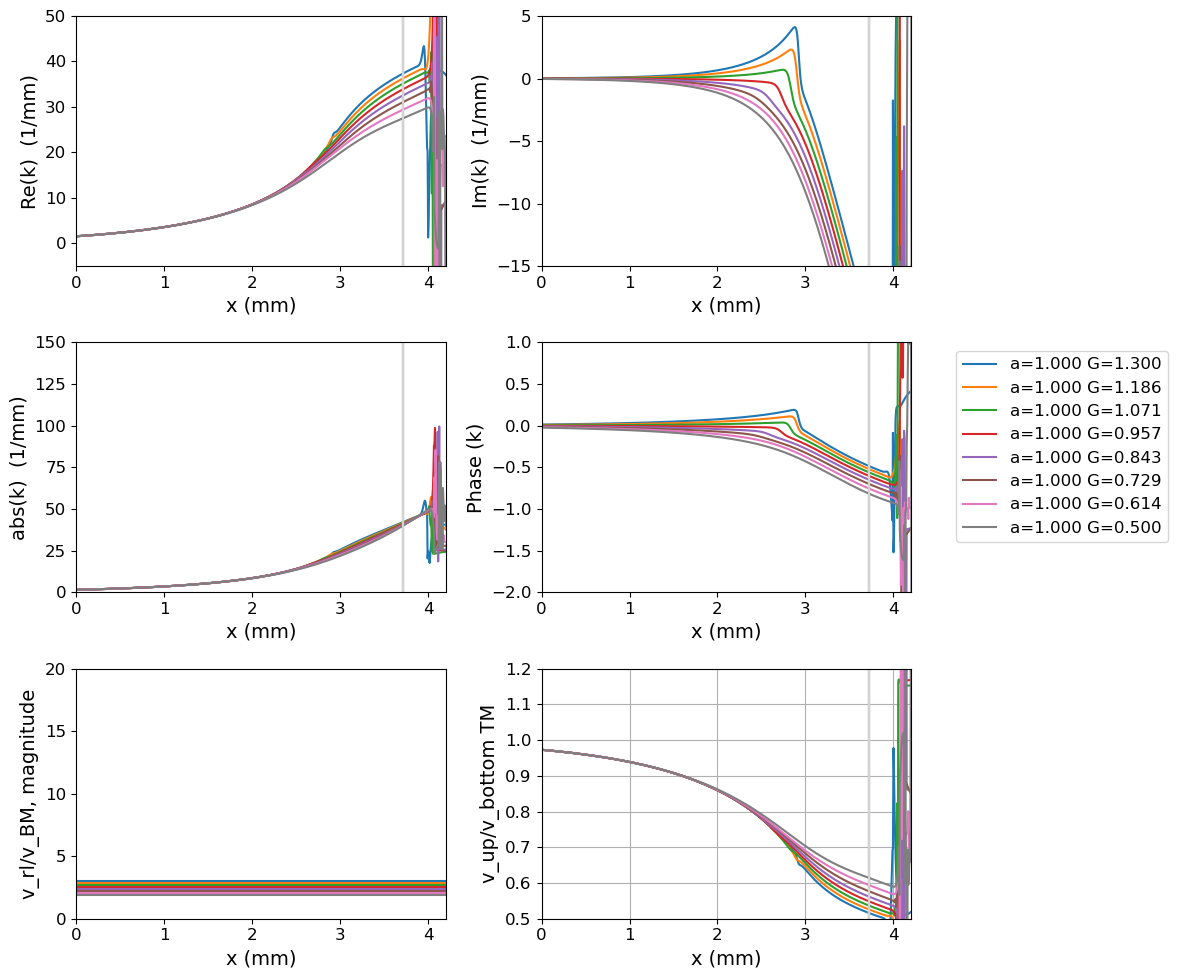

In [16]:
pl.figure(figsize=(12, 10))
for i, tup in enumerate(zip(a_arr, G_arr, ratio_arr)):
    a, G, ratio_v =tup
    plot_k(k_arr[i], ratio_v, label=f'a={a:.3f} G={G:.3f}')
    
#pl.savefig('k.svg')

Same plots with (nominal) CF instead

### WKB approx

In [17]:
def simul_WKB(k, a, G, omega_p, funcVisc=None): #note: mult_factor and scaling symmetry should be set oustide the function
    
    int_k=np.cumsum(k)*(cochl.L/cochl.n_sections)
    func_norm=np.sqrt(k[1]/k)  #same as in code by R Sisto
    if cochl.scaling_symmetry:
        func_norm*=np.sqrt(cochl.omega_bm_x[1]/cochl.omega_bm_x)/10  #tapering geometry (1/sqrt(S))
    p_f=func_norm*np.exp(-1j*int_k)
    alpha=cochl.alpha(k, cochl.omega_bm_x)
    p_BM=alpha*p_f
    
    
    Y_BM=cochl.compute_YBM(cochl.omega_bm_x, a, G, k, omega_p, funcVisc=myFunc)
    visc=cochl.compute_visc(cochl.omega_bm_x, a, G, k, omega_p, funcVisc=myFunc)
    
    v_BM=Y_BM*p_BM
    visc=visc*v_BM
    
    
    return v_BM, p_f, alpha, p_BM, Y_BM, visc

def reduce_arr(tup_arr, ind): #util function to reduce arrays to one element
    return tuple([arr_[ind] for arr_ in tup_arr])

In [18]:
plot_x_min=0
plot_x_max=4  #in mm

f_bm at peak: 17855


/tmp/ipykernel_18509/3050987545.py:47: RuntimeWarning: divide by zero encountered in log10
  plot_1,=pl.plot(cochl.x*1e3, 20*np.log10(np.abs(visc)), label=f'G={G:.2f}')


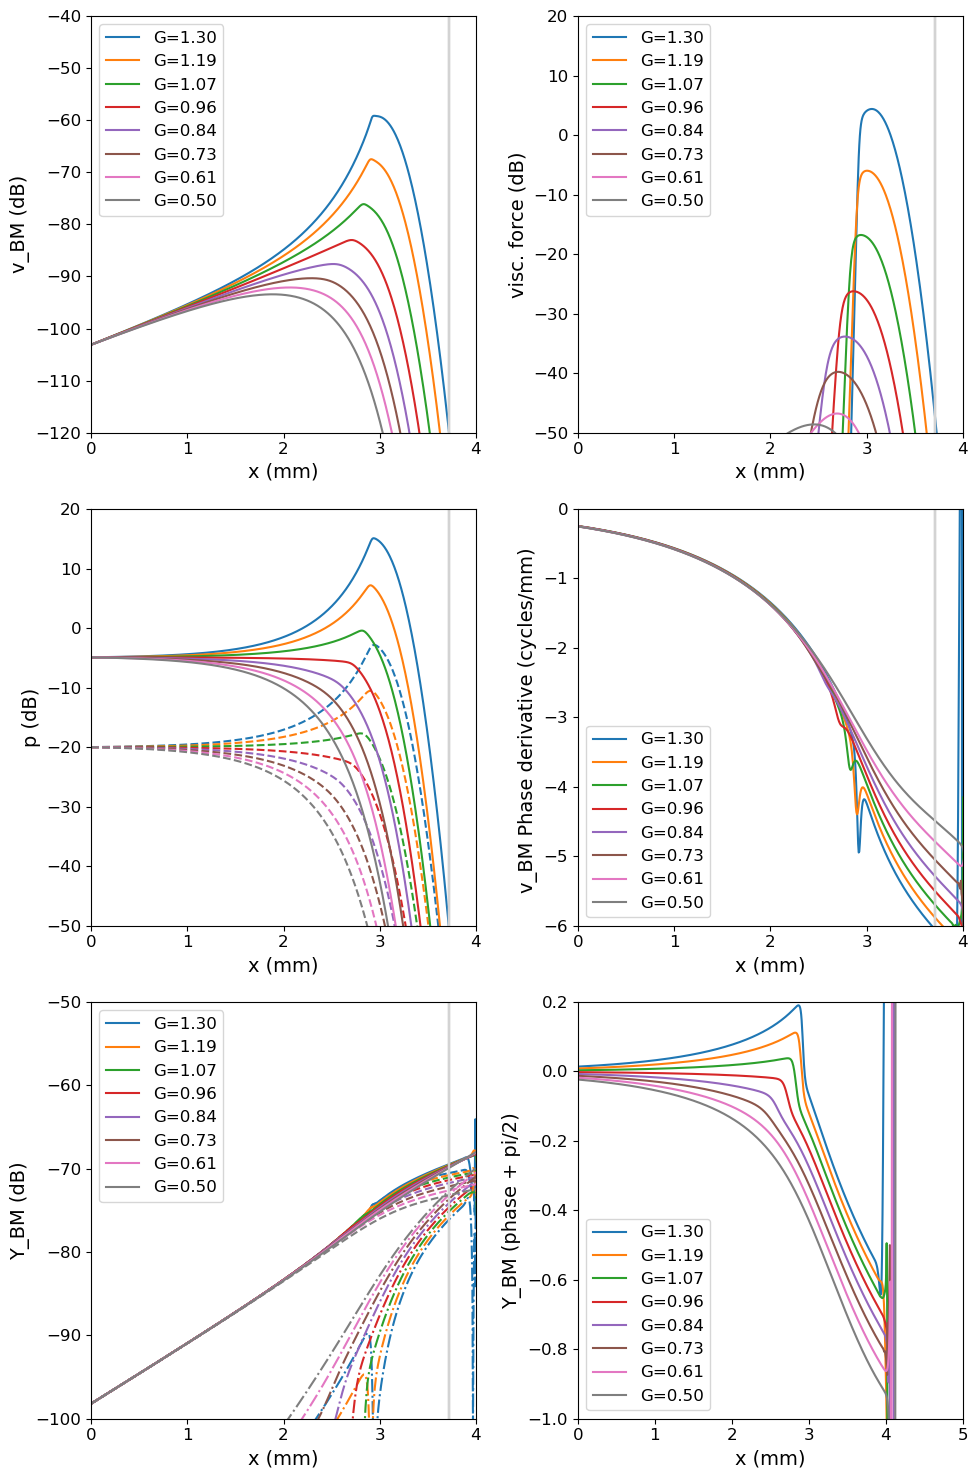

In [19]:
pl.figure(figsize=(10, 15))
for a, G, ratio_v, k, myFunc in zip(a_arr, G_arr, ratio_arr, k_arr, myFuncs):
    
    cochl.set_constant_mult_factor(ratio_v)
    
    #k=compute_k(omega_bm, a, G, omega_p, funcVisc=myFunc) #if need to recompute k
        
    v_BM, p_f, alpha, p_BM, Y_BM, visc=simul_WKB(k, a, G, omega_p, funcVisc=myFunc)  

    pl.subplot(3,2,3)
       
    plot_1,=pl.plot(cochl.x*1e3, 20*np.log10(np.abs(p_BM)), label=f'G={G:.3f}')
    pl.plot(cochl.x*1e3, 20*np.log10(np.abs(p_f)), color=plot_1.get_color(), linestyle='--')
    
    pl.axvline(x_p*1e3, color='lightgray')

    pl.xlabel('x (mm)')
    pl.ylabel('p (dB)')
    pl.xlim([plot_x_min,plot_x_max])
    pl.ylim([-50, 20])
    #pl.legend()

        
    
    pl.subplot(3,2,1)
    
    #if G==G_arr[-1]:
    if G==G_arr[0]:
        #HACK
        ind_fbm=np.sum(cochl.omega_bm_x>1.1*omega_p)
        ind_bm_peak=ind_max=np.argmax(v_BM[:ind_fbm])
        f_bm_peak=cochl.omega_bm_x[ind_max]/(2*np.pi)
        print(f'f_bm at peak: {f_bm_peak:.0f}')
           
    plot_1,=pl.plot(cochl.x*1e3, 20*np.log10(np.abs(v_BM)), label=f'G={G:.2f}')    
    
    pl.axvline(x_p*1e3, color='lightgray')

    pl.xlabel('x (mm)')
    pl.ylabel('v_BM (dB)')
    pl.xlim([plot_x_min, plot_x_max])
    pl.ylim([-120, -40])
    pl.legend()
    
    pl.subplot(3,2,2)
           
    plot_1,=pl.plot(cochl.x*1e3, 20*np.log10(np.abs(visc)), label=f'G={G:.2f}')    
    
    pl.axvline(x_p*1e3, color='lightgray')

    pl.xlabel('x (mm)')
    pl.ylabel('visc. force (dB)')
    pl.xlim([plot_x_min, plot_x_max])
    pl.ylim([-50, 20])
    #pl.ylim([-80, -20])
   
    pl.legend()
    
    
    v_bm_phase=np.unwrap(np.angle(v_BM))
    
    '''pl.subplot(3,2,3)
    
    
    
    plot_1,=pl.plot(cochl.x*1e3, v_bm_phase/(2*np.pi), label=f'G={G:.2f}')    
    
    pl.axvline(x_p*1e3, color='lightgray')

    pl.xlabel('x (mm)')
    pl.ylabel('v_BM (Phase, cycles)')
    pl.xlim([plot_x_min, plot_x_max])
    pl.ylim([-15, 1])
    pl.legend()
    '''
    
    
    pl.subplot(3,2,4)
    
    dx=cochl.x[1]-cochl.x[0]
    phase_deriv=(np.roll(v_bm_phase, -1)-v_bm_phase)/dx
    phase_deriv[-1]=0
        
    plot_1,=pl.plot(cochl.x*1e3, phase_deriv/(2*np.pi)*1e-3, label=f'G={G:.2f}')    
    
    pl.axvline(x_p*1e3, color='lightgray')

    pl.xlabel('x (mm)')
    pl.ylabel('v_BM Phase derivative (cycles/mm) ')
    pl.xlim([plot_x_min, plot_x_max])
    pl.ylim([-6,0])
    pl.legend()
    
    
    pl.subplot(3,2,5)
           
    plot_1,=pl.plot(cochl.x*1e3, 20*np.log10(np.abs(Y_BM)), label=f'G={G:.2f}')    
    
           
    plot_2,=pl.plot(cochl.x*1e3, 20*np.log10(np.abs(np.imag(Y_BM))), color=plot_1.get_color(), linestyle='--')    
    
    plot_2,=pl.plot(cochl.x*1e3, 20*np.log10(np.abs(np.real(Y_BM))), color=plot_1.get_color(), linestyle='-.')    
    
    pl.axvline(x_p*1e3, color='lightgray')

    pl.xlabel('x (mm)')
    pl.ylabel('Y_BM (dB)')
    pl.xlim([plot_x_min, plot_x_max])
    pl.ylim([-100, -50])
    pl.legend()
    
    
    
    
    pl.subplot(3,2,6)
           
    
    plot_1,=pl.plot(cochl.x*1e3,  np.unwrap(np.angle(Y_BM)+np.pi/2), label=f'G={G:.2f}')    
    
    #plot_1,=pl.plot(f_bm_arr, 20*np.log10(np.abs(Y_BM)), label=f'G={G:.2f}')    
    
    pl.xlim([0, 5])
        
    pl.xlabel('x (mm)')
    pl.ylabel('Y_BM (phase + pi/2)')
    
    #pl.ylabel('Y_BM (dB)')
    pl.ylim([-1, 0.2])
    
    #pl.ylim([-75, -50])
    pl.legend()
    pl.tight_layout()
    
    #pl.savefig('WKB_simul.svg')

    
    

In [20]:
freq_p2_arr=np.arange(1, 15)*1e3 #freqs. for probe 2
freq_p2_arr=df_gain['Frequency']

In [21]:
ind_bm_peak

502

In [22]:
np.argmin( (cochl.x-3e-3)**2)

499

In [23]:
#manually chose ind_bm_peak, f_bm_peak
#ind_bm_peak=503
f_bm_peak=cochl.omega_bm_x[ind_bm_peak]/(2*np.pi)


#### Figures paper

In [24]:
cmap = [
    [0, 1.0000, 1.0000],
    [0, 0.8333, 1.0000],
    [0, 0.6667, 1.0000],
    [0, 0.5000, 1.0000],
    [0, 0.3333, 1.0000],
    [0, 0.1667, 1.0000],
    [0, 0, 1.0000],
    [0, 0, 0.8333],
    [0, 0, 0.6667]
]

cmap_viridis= [
    [0.9922, 0.9059, 0.1451],
    [0.6275, 0.8549, 0.2235],
    [0.2902, 0.7569, 0.4275],
    [0.1216, 0.6314, 0.5294],
    [0.1529, 0.4980, 0.5569],
    [0.2118, 0.3608, 0.5529],
    [0.2745, 0.1961, 0.4941],
    [0.2667, 0.0039, 0.3294]
]

cmap_okabe = [
    [0.0, 0.0, 0.0],            # black
    [0.9, 0.6, 0.0],            # orange
    [0.35, 0.7, 0.9],           # sky blue
    [0.0, 0.6, 0.5],            # bluish green
    [0.95, 0.9, 0.25],          # yellow
    [0.0, 0.45, 0.7],           # blue
    [0.8, 0.4, 0.0],            # vermilion
    [0.8, 0.6, 0.7]             # reddish purple
]

cmap_set1 = [pl.cm.Set1(i / 7) for i in range(8)]
# Get 8 colors from Set2
cmap_set2 = [pl.cm.Set2(i / 7) for i in range(8)]


# Load the color cycle from a specific style, e.g., 'tableau-colorblind10'
pl.style.use('tableau-colorblind10')
cmap_custom = pl.rcParams['axes.prop_cycle'].by_key()['color']


cmap_custom=[cmap_custom[ind_] for ind_ in (1,7,2,3,4,5,6,0)]

#cmap_custom=[cmap_custom[ind_] for ind_ in (7,3,4,6,0,2,1,5)]
# Return to default style
pl.style.use('default')


cmap_default=pl.rcParams['axes.prop_cycle'].by_key()['color']

#import cmcrameri.cm as cmc
#cmap_batlow=[cmc.corkO(x_) for x_ in np.linspace(0.5, 1.5, num=8)%1]

markers_arr = ['s', 'o', 'v', '+', '<', 'o', '>', '^'] #'D'

myLabels=['' for G in G_arr]
myLabels[0]='0 dB SPL'
myLabels[-1]='80 dB SPL'



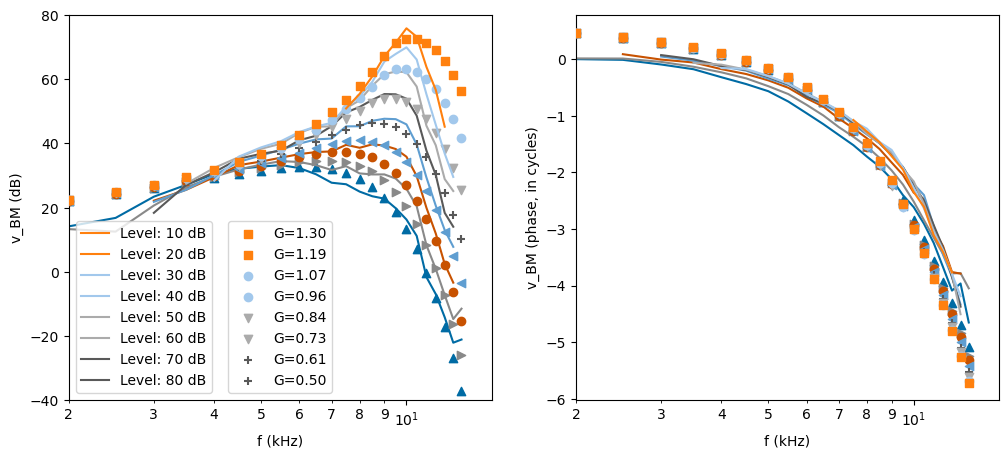

In [25]:
pl.figure(figsize=(12, 5))

plot_lines=[]

plot_lines2=[]

zorder_arr=np.arange(1, 9)
zorder_arr=zorder_arr[::-1]

k2_peak_mat0=[]
damp_peak_mat0=[]
sig_bm2=cochl.sig_bm(2*np.pi*f_bm_peak)

for a, G, ratio_v, k, myFunc, col, c_rgb, zorder, marker in zip(a_arr, G_arr, ratio_arr, k_arr, myFuncs, df_gain.columns[1:], 
                                                cmap_custom, zorder_arr, markers_arr):
    
    cochl.set_constant_mult_factor(ratio_v)
   
    f_bm_arr=cochl.omega_bm_x/(2*np.pi)*1e-3

    
    
    '''#Method 1: use scaling symmetry (approximate bc full model not scaling symmetric)
    f_peak=f_bm_peak
    f_bm_arr=f_p*(f_peak/(cochl.omega_bm_x/(2*np.pi)))*1e-3
    
    #k=compute_k(omega_bm, a, G, omega_p, funcVisc=myFunc) #if need to recompute k
    v_BM, p_f, alpha, p_BM, Y_BM, visc=simul_WKB(k, a, G, omega_p, funcVisc=myFunc) 
    '''
    
    #Method 2: simulate responses to several tone frequencies
    
    v_BM2_arr=[]

    omega_p2_arr=2*np.pi*freq_p2_arr
    k2_peak_arr=[]
    damp_peak_arr=[]
    for omega_p2 in omega_p2_arr:
        k2=compute_k(omega_bm, a, G, omega_p2, funcVisc=myFunc) 
        k2_peak_arr.append(k2[ind_bm_peak])
        tup_arr=simul_WKB(k2, a, G, omega_p2, funcVisc=myFunc) 
        v_BM2, p_f2, alpha2, p_BM2, Y_BM2, visc2= reduce_arr(tup_arr, ind_bm_peak)
        v_BM2_arr.append(v_BM2)
        
        #damp=np.real(visc2/(sig_bm2*v_BM2))
        damp=visc2/(sig_bm2*v_BM2)
       
        damp_peak_arr.append(damp)

    k2_peak_mat0.append(k2_peak_arr)
    
    damp_peak_mat0.append(damp_peak_arr)
    
    v_BM2_arr=np.array(v_BM2_arr)   
    
    pl.subplot(1,2,1)
     
        
    plot_1b,=pl.plot(df_gain['Frequency']/1000, 20*np.log10(df_gain[col]), label=f'{col} dB', color=c_rgb, 
                     zorder=zorder)
    #plot_1b=pl.scatter(df_gain['Frequency']/1000, 20*np.log10(df_gain[col]), label=f'{col} dB', color=c_rgb, 
    #                 marker=marker, zorder=zorder) # marker='o',
    
    plot_lines.append(plot_1b)
    
    plot2=pl.scatter(freq_p2_arr*1e-3, 132+20*np.log10(np.abs(v_BM2_arr)), color=c_rgb, 
                     marker=marker, zorder=zorder)#, label=f'G={G:.2f}'  
    #plot2,=pl.plot(freq_p2_arr*1e-3, 122+20*np.log10(np.abs(v_BM2_arr)), color=c_rgb, zorder=zorder)#, label=f'G={G:.2f}'  
    
    plot_lines2.append(plot2)

    pl.xlim([2, 15])
        
    pl.xlabel('f (kHz)')
    pl.ylabel('v_BM (dB)')
    pl.ylim([-40, 80])
    pl.xscale('log')
    pl.gca().xaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
    
    #pl.legend(loc='upper left')
    
    pl.subplot(1,2,2)
     
        
    plot_1b,=pl.plot(df_gain['Frequency']/1000, df_phase[col]/(2*np.pi), label=f'{col} dB', color=c_rgb, 
                     zorder=zorder)
    #plot_1b=pl.scatter(df_gain['Frequency']/1000, 20*np.log10(df_gain[col]), label=f'{col} dB', color=c_rgb, 
    #                 marker=marker, zorder=zorder) # marker='o',
    
    plot_lines.append(plot_1b)
    
    plot2=pl.scatter(freq_p2_arr*1e-3, np.unwrap(np.angle(v_BM2_arr))/(2*np.pi), color=c_rgb, 
                     marker=marker, zorder=zorder)#, label=f'G={G:.2f}'  
    #plot2,=pl.plot(freq_p2_arr*1e-3, 122+20*np.log10(np.abs(v_BM2_arr)), color=c_rgb, zorder=zorder)#, label=f'G={G:.2f}'  
    
    plot_lines2.append(plot2)

    pl.xlim([2, 15])
        
    pl.xlabel('f (kHz)')
    pl.ylabel('v_BM (phase, in cycles)')
    #pl.ylim([-40, 80])
    pl.xscale('log')
    pl.gca().xaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
    
pl.subplot(1,2,1)
legend1 = pl.legend(plot_lines, [f'Level: {col} dB' for col in df_gain.columns[1:]], loc='lower left')
legend2 = pl.legend(plot_lines2,  [f'G={G:.2f}' for G in G_arr], loc='lower center')
    
pl.gca().add_artist(legend1)

/home/fdeloche/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/fdeloche/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


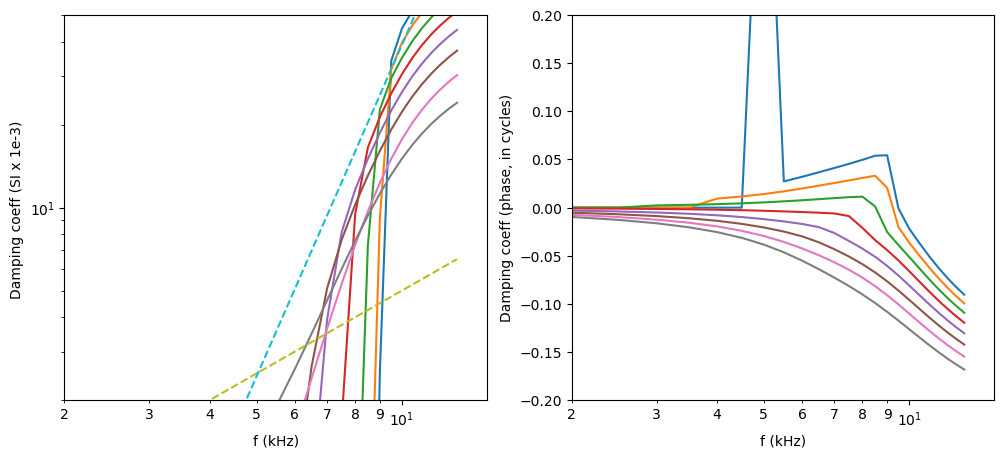

In [26]:
pl.figure(figsize=(12, 5))

damp_peak_mat=np.array(damp_peak_mat0)
damp_peak_mat=damp_peak_mat.T
    
pl.subplot(1,2,1)
    
#pl.plot(freq_p2_arr*1e-3, 20*np.log10(np.abs(k2_peak_mat*1e-3)))

pl.plot(freq_p2_arr*1e-3, damp_peak_mat*1e-3 )

pl.plot(freq_p2_arr*1e-3, (freq_p2_arr/2*1e-3), linestyle='--') #REF

pl.plot(freq_p2_arr*1e-3, (freq_p2_arr/4*1e-3)**4, linestyle='--') #REF



pl.xlim([2, 15])

pl.ylim([2, 50])
    
pl.xlabel('f (kHz)')
#pl.ylabel('|k*1mm| (dB)')


pl.ylabel('Damping coeff (SI x 1e-3) ')

#pl.ylim([-40, 80])

pl.xscale('log')
pl.yscale('log')

pl.gca().xaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())

#pl.legend(loc='upper left')

pl.subplot(1,2,2)
 
    
pl.plot(freq_p2_arr*1e-3, np.unwrap(np.angle(damp_peak_mat))/(2*np.pi))
pl.xlim([2, 15])
pl.ylim([-0.2, 0.2])
pl.xlabel('f (kHz)')
pl.ylabel('Damping coeff (phase, in cycles)')
pl.xscale('log')


pl.gca().xaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())


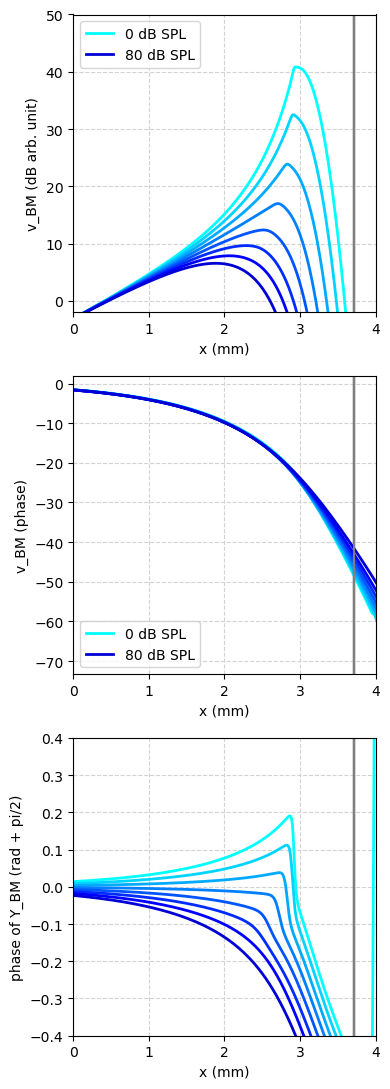

In [27]:
pl.figure(figsize=(4, 11))

#pl.subplot(2,1,2)

#pl.axhline(0, color='lightgray')
for a, G, ratio_v, k, myFunc, c_rgb, label in zip(a_arr, G_arr, ratio_arr, k_arr, myFuncs, cmap, myLabels):
    
    cochl.set_constant_mult_factor(ratio_v)
    

    #k=compute_k(omega_bm, a, G, omega_p, funcVisc=myFunc) #if k needs to be re-computed    
    v_BM, p_f, alpha, p_BM, Y_BM, visc=simul_WKB(k, a, G, omega_p, funcVisc=myFunc)  
    
    
    pl.subplot(3,1,1)

    plot_1,=pl.plot(cochl.x*1e3, 100+20*np.log10(np.abs(v_BM)), label=label, color=c_rgb, linewidth=2)    
    
    pl.axvline(x_p*1e3, color='gray')

    pl.xlabel('x (mm)')
    pl.ylabel('v_BM (dB arb. unit)')
    pl.xlim([plot_x_min, plot_x_max])
    pl.ylim([-2, 50])
    pl.grid(color='lightgray', linestyle='--')
    pl.legend()


    pl.subplot(3,1,2)
    
    plot_1,=pl.plot(cochl.x*1e3, np.unwrap(np.angle(v_BM)), label=label, color=c_rgb, linewidth=2)    
    
    pl.axvline(x_p*1e3, color='gray')

    pl.xlabel('x (mm)')
    pl.ylabel('v_BM (phase)')
    pl.xlim([plot_x_min, plot_x_max])
    #pl.ylim([-2, 50])
    pl.grid(color='lightgray', linestyle='--')
    pl.legend()
    
    
    
    pl.subplot(3,1,3)
           
    
    plot_1,=pl.plot(cochl.x*1e3,  np.unwrap(np.angle(Y_BM)+np.pi/2), label=label, color=c_rgb, linewidth=2)    
    
    #plot_1,=pl.plot(f_bm_arr, 20*np.log10(np.abs(Y_BM)), label=f'G={G:.2f}')    
    
    pl.xlim([plot_x_min, plot_x_max])
        
    pl.xlabel('x (mm)')
    pl.ylabel('phase of Y_BM (rad + pi/2)')
    
    #pl.ylabel('Y_BM (dB)')
    pl.ylim([-0.4, 0.4])
    
    
    pl.grid(color='lightgray', linestyle='--')
    pl.axvline(x_p*1e3, color='gray')
    #pl.ylim([-75, -50])
    #pl.legend()
    pl.tight_layout()
    
    
    

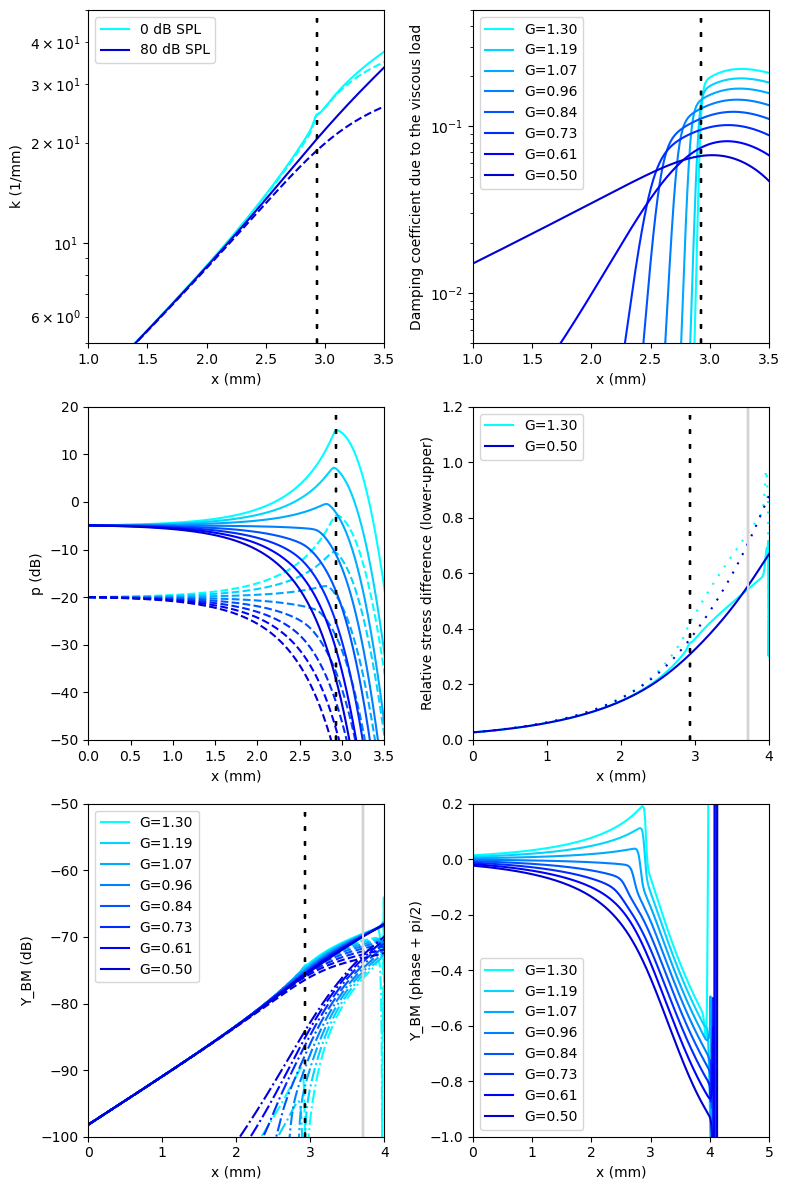

In [28]:
b_place=2.93
plot_x_min2=1
plot_x_max2=3.5
pl.figure(figsize=(8, 12))
for a, G, ratio_v, k, myFunc, c_rgb, label in zip(a_arr, G_arr, ratio_arr, k_arr, myFuncs, cmap, myLabels):
    
    cochl.set_constant_mult_factor(ratio_v)
    
    #k=compute_k(omega_bm, a, G, omega_p, funcVisc=myFunc) #if need to recompute k
        
    v_BM, p_f, alpha, p_BM, Y_BM, visc=simul_WKB(k, a, G, omega_p, funcVisc=myFunc)  

    pl.subplot(3,2,3)
       
    
    plot_1,=pl.plot(cochl.x*1e3, 20*np.log10(np.abs(p_BM)), label=f'G={G:.3f}', color=c_rgb,)
    pl.plot(cochl.x*1e3, 20*np.log10(np.abs(p_f)), color=c_rgb, linestyle='--')
    
    pl.axvline(x_p*1e3, color='lightgray')
    
    
    pl.axvline(b_place, color='black', linestyle='--', linewidth=1.5, dashes=(2, 5))

    pl.xlabel('x (mm)')
    pl.ylabel('p (dB)')
    pl.xlim([plot_x_min,plot_x_max2])
    pl.ylim([-50, 20])
    #pl.legend()

        
    
    pl.subplot(3,2,1)
    
    #plot_1,=pl.plot(cochl.x*1e3, np.abs(alpha), label=f'G={G:.2f}',  color=c_rgb,)    
    
    #pl.plot(cochl.x*1e3, np.abs(k*1e-3), color=c_rgb, linestyle='--')    
    #pl.plot(cochl.x, np.abs(k*cochl.H(cochl.omega_bm_x)), color=c_rgb, linestyle='--')    
    
    if G==G_arr[0] or G==1. or G==G_arr[-1]:
        pl.plot(cochl.x*1e3, np.abs(k*1e-3), color=c_rgb, label=label)    
        pl.plot(cochl.x*1e3, np.real(k*1e-3), color=c_rgb, linestyle='--')    
        
    #pl.plot(cochl.x*1e3, np.imag(k*1e-3), color=c_rgb, linestyle='-.')    
    
    
    
    pl.axvline(b_place, color='black', linestyle='--', linewidth=1.5, dashes=(2, 5))
    pl.axvline(x_p*1e3, color='lightgray')

    pl.xlabel('x (mm)')
    
    pl.ylabel('k (1/mm)')
    
    #pl.ylabel('alpha (magnitude)')
    pl.xlim([plot_x_min2, plot_x_max2])
    pl.ylim([5, 5*1e1])
    pl.yscale('log')
    pl.legend()
    
    
    
    pl.subplot(3,2,2)
         
    sig_bm=cochl.sig_bm(cochl.omega_bm_x)

    damp_ratio=visc/(2*sig_bm*v_BM*2*np.pi*f_bm_peak) #note: /S_BM is implicit in this formula (it is inside visc)




    plot_1,=pl.plot(cochl.x*1e3, np.real(damp_ratio), label=f'G={G:.2f}',  color=c_rgb)    


    pl.axvline(b_place, color='black', linestyle='--', linewidth=1.5, dashes=(2, 5))
    pl.axvline(x_p*1e3, color='lightgray')

    pl.xlabel('x (mm)')
    
    #pl.ylabel('Damping coefficient due to viscous load (SI)')
    pl.ylabel('Damping coefficient due to the viscous load')

    pl.yscale('log')
    pl.xlim([plot_x_min2, plot_x_max2])
    #pl.ylim([1e3, 1e5])
    pl.ylim([1e-2/2, 1/2])
    pl.legend()
    

    
    v_bm_phase=np.unwrap(np.angle(v_BM))
    
    
    pl.subplot(3,2,4)
    
    k_z=k/np.sqrt(2)
    diff_stress=1-np.exp(-k_z*cochl.H_TM)
        
    if G==G_arr[-1] or G == G_arr[0]:
        plot_1,=pl.plot(cochl.x*1e3, np.abs(diff_stress), label=f'G={G:.2f}', color=c_rgb)   

        plot_1,=pl.plot(cochl.x*1e3, np.abs(k_z*cochl.H_TM), color=c_rgb, linestyle='--', dashes=(1, 4)) #approx    

    
    
    pl.axvline(b_place, color='black', linestyle='--', linewidth=1.5, dashes=(2, 5))
    pl.axvline(x_p*1e3, color='lightgray')

    pl.xlabel('x (mm)')
    pl.ylabel('Relative stress difference (lower-upper)')
    pl.xlim([plot_x_min, plot_x_max])
    pl.ylim([0,1.2])
    
    pl.legend()
    
    
    pl.subplot(3,2,5)
           
    plot_1,=pl.plot(cochl.x*1e3, 20*np.log10(np.abs(Y_BM)), label=f'G={G:.2f}',  color=c_rgb)    
    
           
    plot_2,=pl.plot(cochl.x*1e3, 20*np.log10(np.abs(np.imag(Y_BM))), color=plot_1.get_color(), linestyle='--')    
    
    plot_2,=pl.plot(cochl.x*1e3, 20*np.log10(np.abs(np.real(Y_BM))), color=plot_1.get_color(), linestyle='-.')    
    
    
    
    pl.axvline(b_place, color='black', linestyle='--', linewidth=1.5, dashes=(2, 5))
    pl.axvline(x_p*1e3, color='lightgray')

    pl.xlabel('x (mm)')
    pl.ylabel('Y_BM (dB)')
    pl.xlim([plot_x_min, plot_x_max])
    pl.ylim([-100, -50])
    pl.legend()
    
    
    
    
    pl.subplot(3,2,6)
           
    
    plot_1,=pl.plot(cochl.x*1e3,  np.unwrap(np.angle(Y_BM)+np.pi/2), label=f'G={G:.2f}', color=c_rgb)    
    
    #plot_1,=pl.plot(f_bm_arr, 20*np.log10(np.abs(Y_BM)), label=f'G={G:.2f}')    
    
    pl.xlim([0, 5])
        
    pl.xlabel('x (mm)')
    pl.ylabel('Y_BM (phase + pi/2)')
    
    #pl.ylabel('Y_BM (dB)')
    pl.ylim([-1, 0.2])
    
    #pl.ylim([-75, -50])
    pl.legend()
    pl.tight_layout()
    

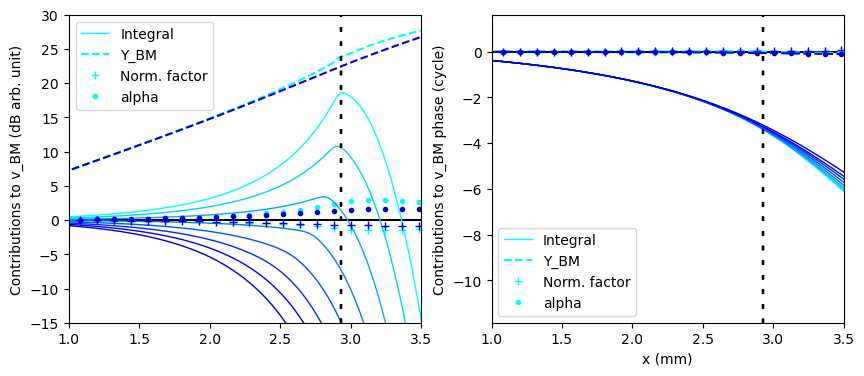

In [29]:
b_place=2.93
pl.figure(figsize=(10, 4))

pl.subplot(1,2,1)
pl.axhline(0, color='black')

pl.subplot(1,2,2)
pl.axhline(0, color='black')


for a, G, ratio_v, k, myFunc, c_rgb, label in zip(a_arr, G_arr, ratio_arr, k_arr, myFuncs, cmap, myLabels):
    
    cochl.set_constant_mult_factor(ratio_v)
    
    #k=compute_k(omega_bm, a, G, omega_p, funcVisc=myFunc) #if need to recompute k
        
    funcVisc=myFunc  
    
    int_k=np.cumsum(k)*(cochl.L/cochl.n_sections)
    func_norm=np.sqrt(k[1]/k)  #same as in code by R Sisto
    if cochl.scaling_symmetry:
        func_norm*=np.sqrt(cochl.omega_bm_x[1]/cochl.omega_bm_x)/10  #tapering geometry (1/sqrt(S))
    p_f=func_norm*np.exp(-1j*int_k)
    alpha=cochl.alpha(k, cochl.omega_bm_x)
    p_BM=alpha*p_f
    
    
    Y_BM=cochl.compute_YBM(cochl.omega_bm_x, a, G, k, omega_p, funcVisc=myFunc)
    visc=cochl.compute_visc(cochl.omega_bm_x, a, G, k, omega_p, funcVisc=myFunc)
    
    v_BM=Y_BM*p_BM
    visc=visc*v_BM

    pl.subplot(1,2,1)
    
    linewidth=3 if G==1. else 1 
    pl.plot(cochl.x*1e3, 20*np.log10(np.abs(np.exp(-1j*int_k)/np.exp(-1j*int_k[0]))), label=f'Integral', 
            linewidth=linewidth, color=c_rgb)    

    
    if G == G_arr[0] or G ==G_arr[-1]:
        pl.plot(cochl.x*1e3, 20*np.log10(np.abs(Y_BM/Y_BM[0])), label=f'Y_BM', color=c_rgb, linestyle='--')    

        func_norm_curve=20*np.log10(np.abs(func_norm/func_norm[0]))
        plot_1,=pl.plot(cochl.x[0::20]*1e3, func_norm_curve[0::20], label=f'Norm. factor', color=c_rgb,
                        marker='+', linewidth=0)    

        alpha_curve= 20*np.log10(np.abs(alpha/alpha[0]))
        pl.plot(cochl.x[0::20]*1e3, alpha_curve[0::20], label=f'alpha', color=c_rgb,
                marker='o', linewidth=0, markersize=3)


    pl.axvline(b_place, color='black', linestyle='--', linewidth=1.5, dashes=(2, 5))
    pl.axvline(x_p*1e3, color='lightgray')
    
    pl.xlim([plot_x_min2, plot_x_max2])
    pl.ylim([-15, 30])
    
    if G == G_arr[0]:
        pl.legend()
    
    pl.ylabel('Contributions to v_BM (dB arb. unit)')
    
    pl.subplot(1,2,2)
    
    linewidth=3 if G==1. else 1 
    pl.plot(cochl.x*1e3, 1/(2*np.pi)*np.unwrap(np.angle(np.exp(-1j*int_k)/np.exp(-1j*int_k[0]))), label=f'Integral', 
            linewidth=linewidth, color=c_rgb)    
    
    if G == G_arr[0] or G ==G_arr[-1]:
        pl.plot(cochl.x*1e3, 1/(2*np.pi)*np.unwrap(np.angle(Y_BM/Y_BM[0])), label=f'Y_BM', color=c_rgb, linestyle='--')    

        func_norm_curve=1/(2*np.pi)*np.unwrap(np.angle(func_norm/func_norm[0]))
        plot_1,=pl.plot(cochl.x[0::20]*1e3, func_norm_curve[0::20], label=f'Norm. factor', color=c_rgb,
                        marker='+', linewidth=0)    

        alpha_curve= 1/(2*np.pi)*np.unwrap(np.angle(alpha/alpha[0]))
        pl.plot(cochl.x[0::20]*1e3, alpha_curve[0::20], label=f'alpha', color=c_rgb,
                marker='o', linewidth=0, markersize=3)


    pl.axvline(b_place, color='black', linestyle='--', linewidth=1.5, dashes=(2, 5))
    pl.axvline(x_p*1e3, color='lightgray')
    
    pl.xlim([plot_x_min2, plot_x_max2])
    
    if G == G_arr[0]:
        pl.legend()
    
    pl.ylabel('Contributions to v_BM phase (cycle)')
    
    pl.xlabel('x (mm)')

Text(0.5, 0, 'f/CF')

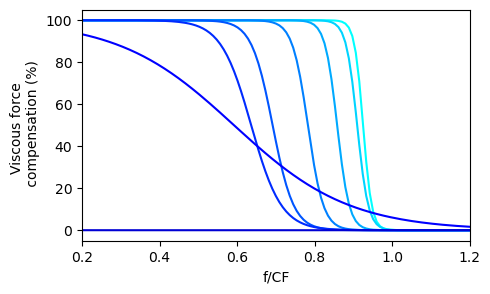

In [30]:
pl.figure(figsize=(5, 3))
for myFunc, c_rgb in zip(myFuncs, cmap):
    x=np.linspace(0, 1, num=200)
    pl.plot(x/f_p_to_f_bm, myFunc(x)*100, color=c_rgb)

pl.xlim([0.2, 1.2])
pl.ylabel('Viscous force \n compensation (%)')
pl.xlabel('f/CF')